In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error 
from ta import add_all_ta_features

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from src.visualization.visualize import DisplayTicker
from src.features.build_features import StockTechnicals
from src.models.backtest_strategy import TradeHoldStrategy


# Convert Data Function

The function below will load a CSV file with a start and end date to filter out the time range for testing. 

In addition, for feature selection, I used the following subset features for regression, there were over 85s features in the TA library:

data_df['SMA_20'] = indicator_SMA20.sma_indicator()

data_df['bb_bbm'] = indicator_bb.bollinger_mavg()

data_df['bb_bbh'] = indicator_bb.bollinger_hband()

data_df['bb_bbl'] = indicator_bb.bollinger_lband()

data_df['MACD'] = indicator_MACD.macd()

data_df['MACD signal'] = indicator_MACD.macd_signal()


In [3]:
def convert_data(stock_ticker_csv, start_date, end_date):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    """

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
 

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)

    indicator_bb = ta.volatility.BollingerBands(close=data_df["Close"], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df["Close"],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df["Close"],n_fast=5, n_slow=30, fillna=True)
  
    # Features added to original date
    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()
 
    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates




In [4]:


def svc_param_selection(X, y, nfolds, model):
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel=model), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_

# Model Training and Prediction Function

This function takes the ticker dataframe, forecasted number of dates (5 in this case), and tries to predict a price based on the best parameters.

In [5]:
def predict_multiple_variables(ticker_df, dates_org, num_forecast_days, C_user=1000, G_user=0.008, model =  'rbf'):

    #features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    features=['Date','SMA_20','Open', 'bb_bbl']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)
    #print(f'{type(dates_org[-num_forecast_days:])}')
    #print(f'{type(dates_org[-num_forecast_days:].values)}')
    
    #print(dates_org[-num_forecast_days:])
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Adj Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Adj Close']]
    
    # removed Grid Search due to performance issues
    #best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)
    """
    if C_user is None or G_user is None:
        #C_user = best_params["C"]
        #G_user = best_params["gamma"]
        C_user = 1000
        G_user = 0.008
        #print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
        print(f'Using Default values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')
    """
    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    
    svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    
    
    y_pred = svr_rbf.predict(test_x)
    print("=" * 100)
    print("Predicted Values: {}".format(y_pred))
    print("-" * 100)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 100)
    print(f"Model Score: {svr_rbf.score(train_x, train_y)}")
    print("-" * 100)
    print(f"Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 100)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 100)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 100)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

    



In [25]:
def predict_using_random_forest(ticker_df, dates_org, num_forecast_days, estimators_user=1000, criterion_user='mse', state = 1, n_jobs= -1, max_depth=3):

    #features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    features=['Date','SMA_20','Open', 'bb_bbl']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)

    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Adj Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Adj Close']]
    
    # removed Grid Search due to performance issues
    #best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)
    """
    if C_user is None or G_user is None:
        #C_user = best_params["C"]
        #G_user = best_params["gamma"]
        C_user = 1000
        G_user = 0.008
        #print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
        print(f'Using Default values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')
    """
    # Fit training data using SVR/RBF
    #svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    rand_forest = RandomForestRegressor(n_estimators=estimators_user, criterion=criterion_user, random_state=state, n_jobs=n_jobs, max_depth=max_depth)
    #svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    rand_forest.fit(train_x, train_y.values.reshape(-1,))
    y_train_pred = rand_forest.predict(train_x)

    y_pred = rand_forest.predict(test_x)
    print("=" * 100)
    print("Test Data Predicted Values: {}".format(y_pred))
    print("-" * 100)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 100)
    print(f"Train Model Score: {rand_forest.score(train_x, y_train_pred)}")
    print("-" * 100)
    print(f"Test Model Score: {rand_forest.score(test_x, y_pred)}")
    print("-" * 100)
    print(f"Train Model R2 Score: {r2_score(train_y, y_train_pred)}")
    print("-" * 100)
    print(f"Test Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 100)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 100)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 100)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        y_train_pred, 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], rand_forest.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], rand_forest.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

In [6]:
def corr_plot(df):
    corrMatrix = df.drop(columns=['index','Date','Pretty Date']).corr()
    print(corrMatrix.shape)
    import seaborn as sn
    sn.heatmap(corrMatrix, 
            annot=True, 
            vmin = -1, 
            vmax=1, 
            center=0,
            fmt='.2g',
            linewidths=10,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 1.0},
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
    plt.figure(figsize = (125,125))
    plt.show()


# Predicting Microsoft Stock Prices

SVR fails to predict well with the training data. The prediction numbers are off quite a bit, even with day 1. In looking at the chart below, it is obvious that the model appears to be overfitting and therefore cannot take properly deal with unseen data.

# Date Selection

For data selection, I choose to use 2019. as a training year to test how well SVR would perform. This helped test a few scenarios for the data. 

In [7]:
start_date = '2019-06-30'
end_date = '2019-12-31'
MSFT, MSFT_dates = convert_data('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data('./.data/_GSPC.csv',start_date, end_date)

# Correlation Matrix based for Microsoft

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


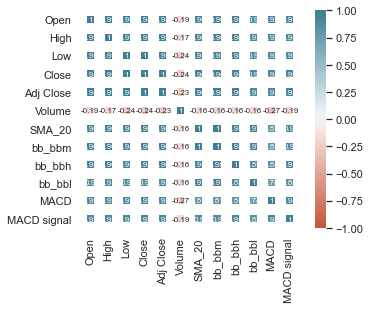

<Figure size 9000x9000 with 0 Axes>

In [8]:
corr_plot(MSFT)

# Using Random Forests

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [156.8116946 156.981232  155.4135134 156.981232  156.4726198]
----------------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
----------------------------------------------------------------------------------------------------
Train Model Score: 1.0
----------------------------------------------------------------------------------------------------
Test Model Score: 1.0
----------------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9919583706239412
----------------------------------------------------------------------------------------------------
Test Model R2 Score: -5.028269590197008
----------------------------------------------------------------------------------------------------
Mean Sq

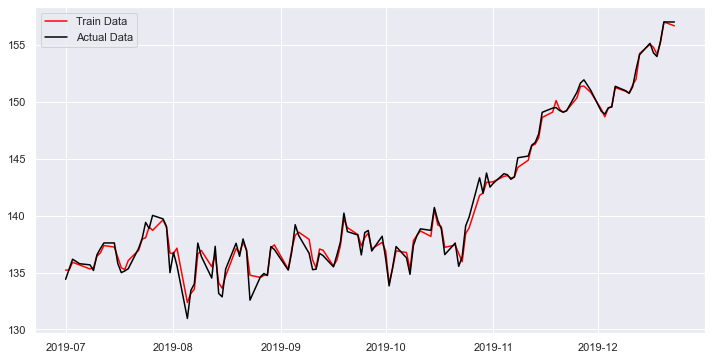

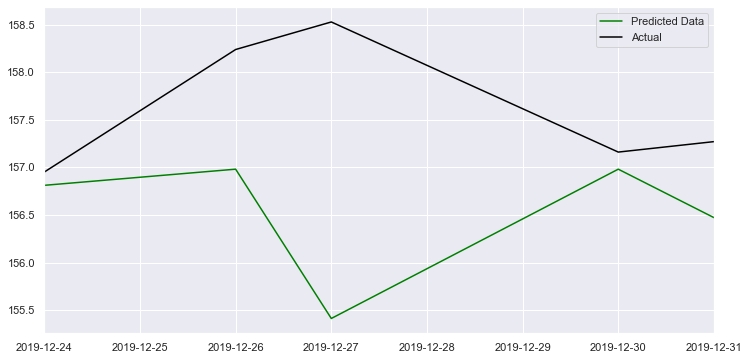

In [32]:
predict_using_random_forest(MSFT, MSFT_dates, num_forecast_days=5, estimators_user=10, max_depth=None)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [157.6133193  156.02719854 152.66674404 148.23089127 148.99472025]
----------------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
----------------------------------------------------------------------------------------------------
Model Score: 0.9902692546409707
----------------------------------------------------------------------------------------------------
Model R2 Score: -93.69892764480346
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 37.57944217944612
----------------------------------------------------------------------------------------------------
RMSE: 6.130207352075957


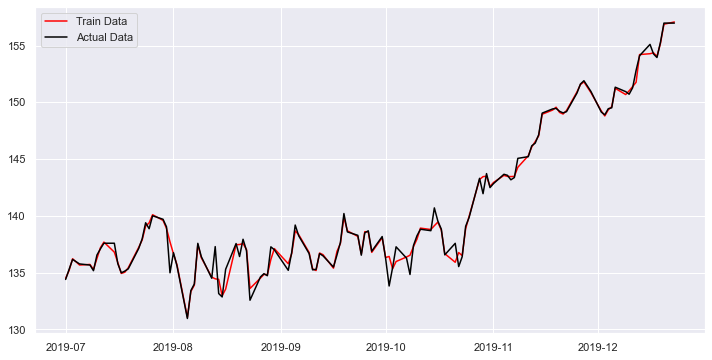

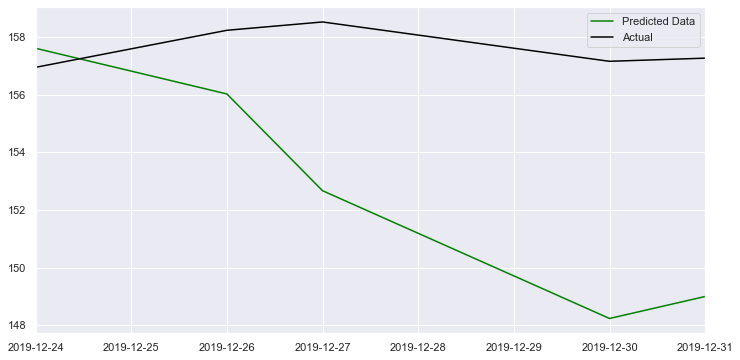

In [9]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 1000, G_user=.009, model = 'rbf')


Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [138.0612965 138.0612965 138.0612965 138.0612965 138.0612965]
----------------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
----------------------------------------------------------------------------------------------------
Model Score: -0.16597501865598852
----------------------------------------------------------------------------------------------------
Model R2 Score: -964.9274770117726
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 383.30968126748434
----------------------------------------------------------------------------------------------------
RMSE: 19.57829617886818


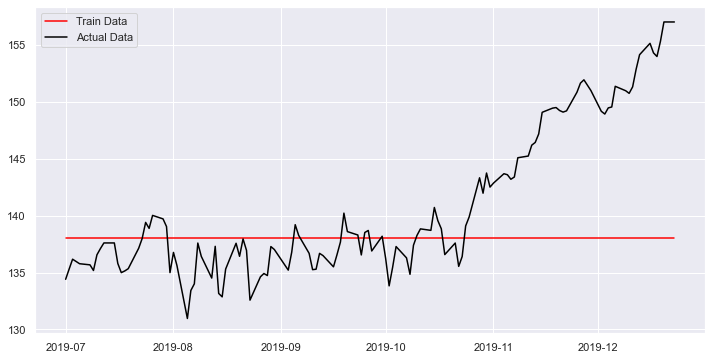

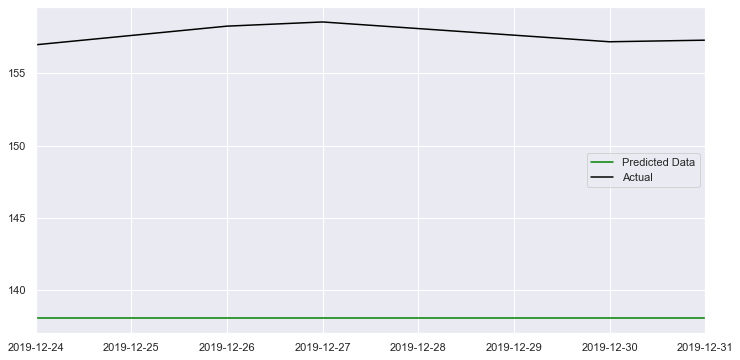

In [10]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 1000, G_user=.009, model = 'sigmoid')

# Predicting Apple Stock Prices

# Correlation Matrix based for Apple

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


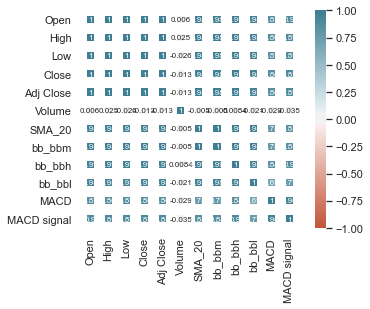

<Figure size 9000x9000 with 0 Axes>

In [11]:
corr_plot(AAPL)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [276.64068691 275.14590349 252.20695444 253.64934752 249.31602016]
----------------------------------------------------------------------------------------------------
Actual Values: [283.596924 289.223602 289.113831 290.829773 292.954712]
----------------------------------------------------------------------------------------------------
Model Score: 0.9991920554458561
----------------------------------------------------------------------------------------------------
Model R2 Score: -100.68968044615977
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 979.0815663722481
----------------------------------------------------------------------------------------------------
RMSE: 31.290279103457163


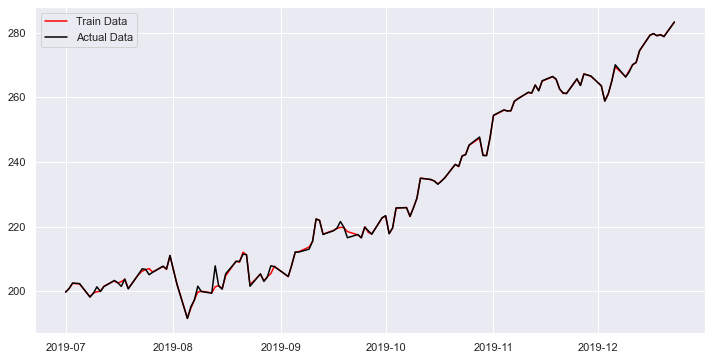

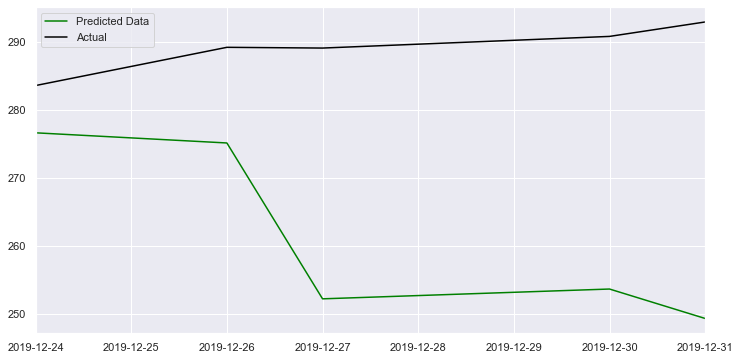

In [22]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='rbf')


Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [219.9118285 219.9118285 219.9118285 219.9118285 219.9118285]
----------------------------------------------------------------------------------------------------
Actual Values: [283.596924 289.223602 289.113831 290.829773 292.954712]
----------------------------------------------------------------------------------------------------
Model Score: -0.13624417543667477
----------------------------------------------------------------------------------------------------
Model R2 Score: -497.8184752628834
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 4802.68963333382
----------------------------------------------------------------------------------------------------
RMSE: 69.30144034097574


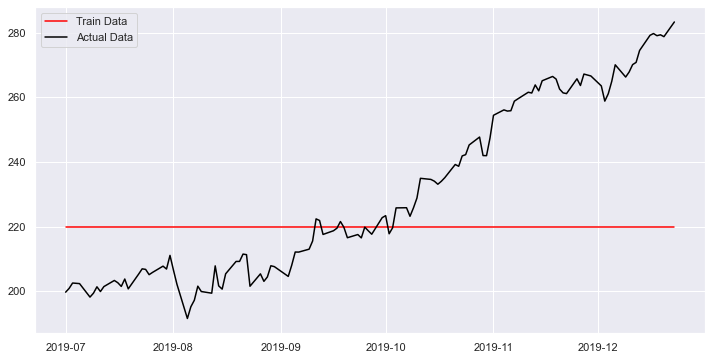

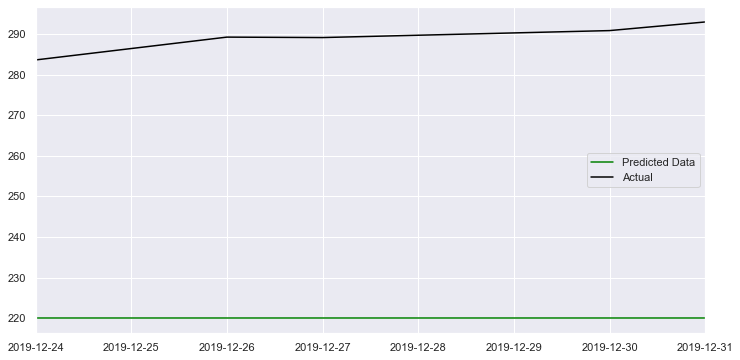

In [12]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='sigmoid', C_user=1000, G_user=.0009)

# Predicting Amazon Stock Prices

# Correlation Matrix based for Amazon

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


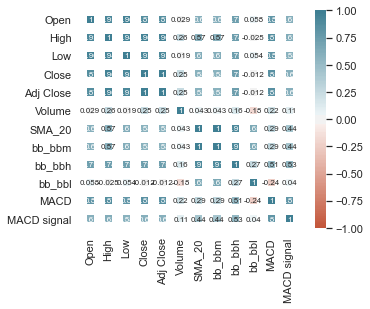

<Figure size 9000x9000 with 0 Axes>

In [12]:
corr_plot(AMZN)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 1e-05 values
Predicted Values: [1782.58243493 1794.68031319 1847.22087574 1844.51127517 1829.38742208]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Model Score: 0.744081271211206
----------------------------------------------------------------------------------------------------
Model R2 Score: -0.484826610115757
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 1277.8365206262747
----------------------------------------------------------------------------------------------------
RMSE: 35.746839309598755


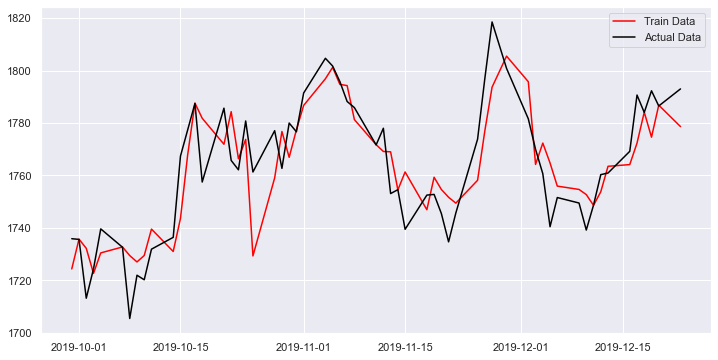

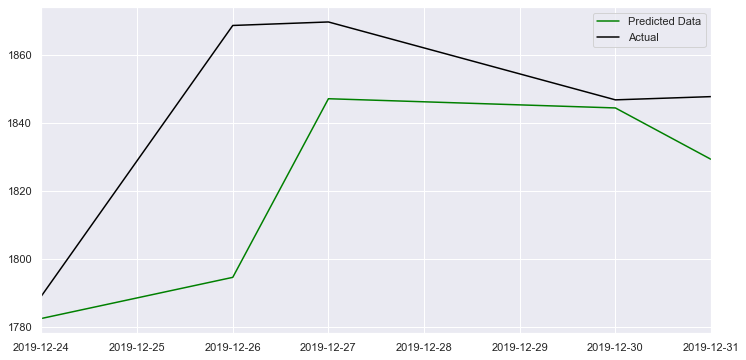

In [26]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=1000, G_user=.00001)


Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [1786.350012 1786.350012 1786.350012 1786.350012 1786.350012]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Model Score: -0.0955125129506329
----------------------------------------------------------------------------------------------------
Model R2 Score: -3.9294304953952466
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 4242.250421693241
----------------------------------------------------------------------------------------------------
RMSE: 65.13256038029859


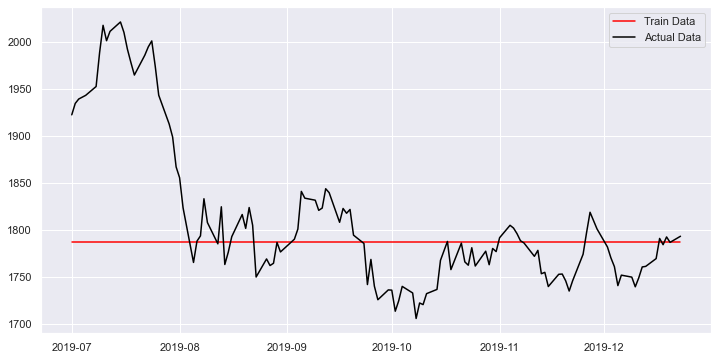

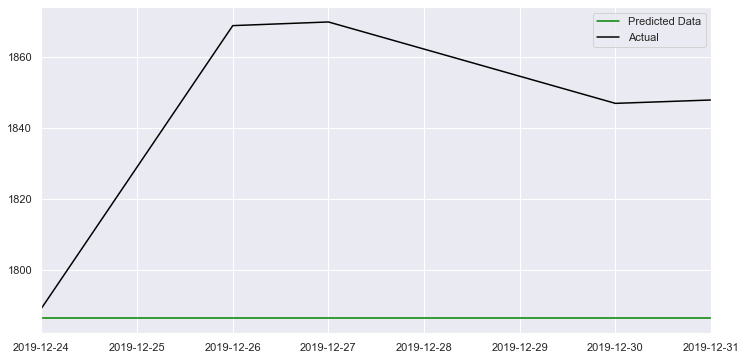

In [13]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=1000, G_user=.00001, model='sigmoid')

# Predicting Google Stock Prices

SVR does a poor job of adapting to unpredicted spikes when

# Correlation Matrix based for Google

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


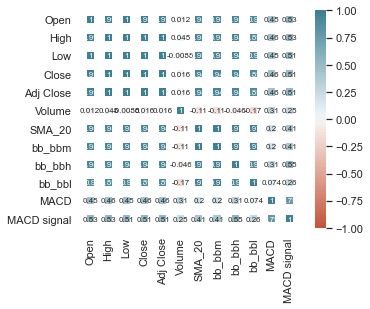

<Figure size 9000x9000 with 0 Axes>

In [14]:
corr_plot(GOOG)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [3218.2116176  3198.64956613 3114.33800395 3124.72670998 3114.76548207]
----------------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
----------------------------------------------------------------------------------------------------
Model Score: 0.9961890634783441
----------------------------------------------------------------------------------------------------
Model R2 Score: -127.73472984903384
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 8061.789575408999
----------------------------------------------------------------------------------------------------
RMSE: 89.78746892194366


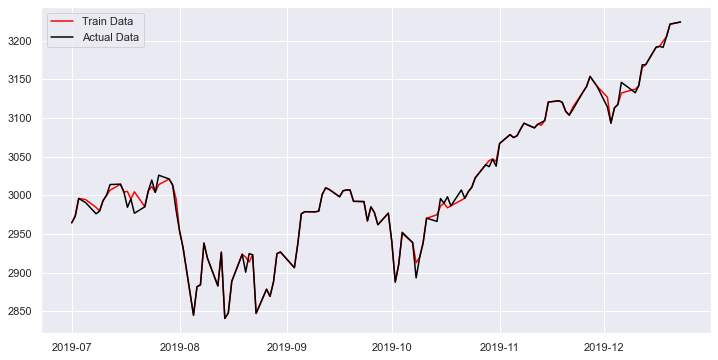

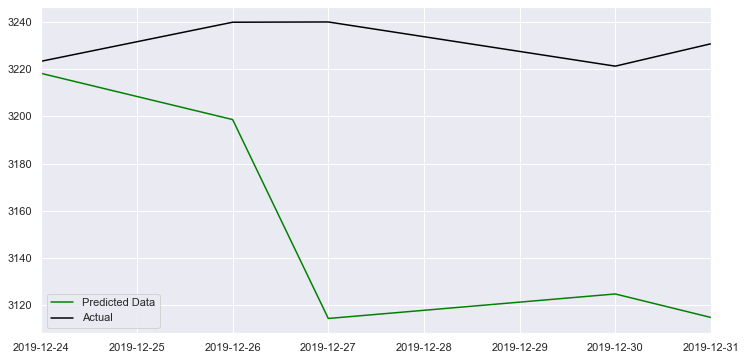

In [15]:
predict_multiple_variables(_GSPC, _GSPC_dates , num_forecast_days=5, C_user=1000, G_user=.0009,model =  'rbf')


Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [1225.2149905 1225.2149905 1225.2149905 1225.2149905 1225.2149905]
----------------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
----------------------------------------------------------------------------------------------------
Model Score: -0.011653543161776803
----------------------------------------------------------------------------------------------------
Model R2 Score: -170.80420243813182
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 14626.367206912595
----------------------------------------------------------------------------------------------------
RMSE: 120.93951879725913


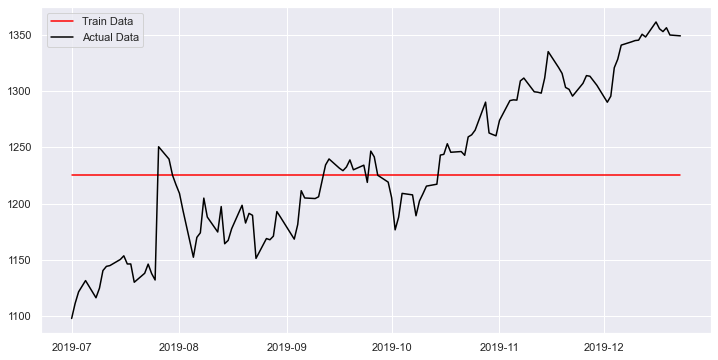

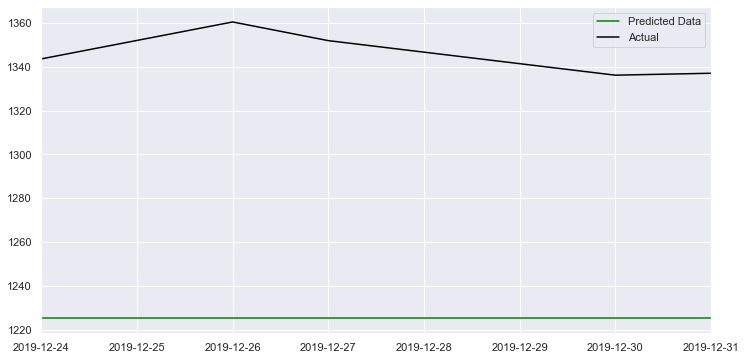

In [16]:
predict_multiple_variables(GOOG, GOOG_dates, num_forecast_days=5, C_user=1000, G_user=.0001,model =  'sigmoid')

# Predicting the S&P Index



Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [3226.86188458 3227.87676759 3218.7004044  3222.47609676 3227.90655539]
----------------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
----------------------------------------------------------------------------------------------------
Model Score: 0.9720509429994367
----------------------------------------------------------------------------------------------------
Model R2 Score: -0.9836412413128668
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 124.22209841369745
----------------------------------------------------------------------------------------------------
RMSE: 11.14549677734005


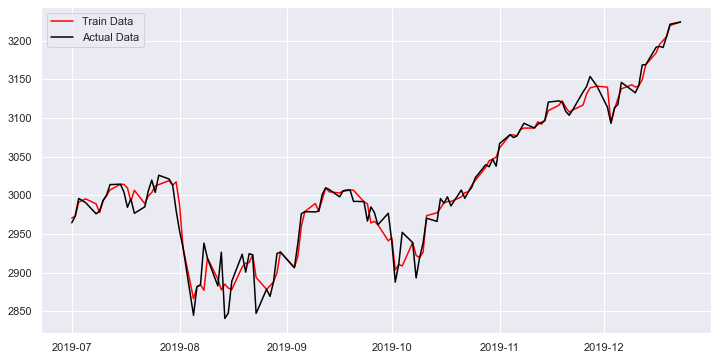

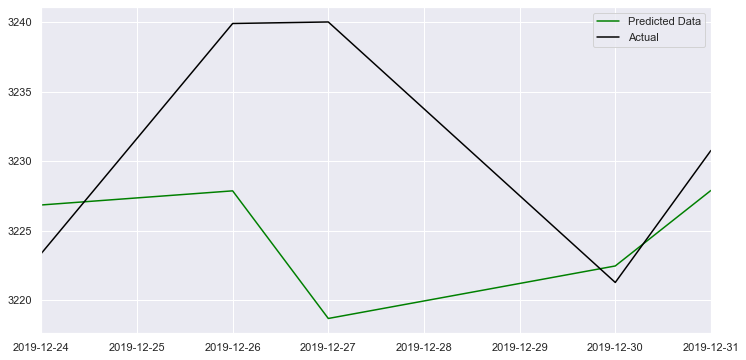

In [17]:
predict_multiple_variables(_GSPC, _GSPC_dates, num_forecast_days=5, C_user=1000, G_user=.0001,model =  'rbf')

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Predicted Values: [2997.854956 2997.854956 2997.854956 2997.854956 2997.854956]
----------------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
----------------------------------------------------------------------------------------------------
Model Score: -0.02388155205412068
----------------------------------------------------------------------------------------------------
Model R2 Score: -868.5596520068241
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 54454.667718382625
----------------------------------------------------------------------------------------------------
RMSE: 233.35523932061741


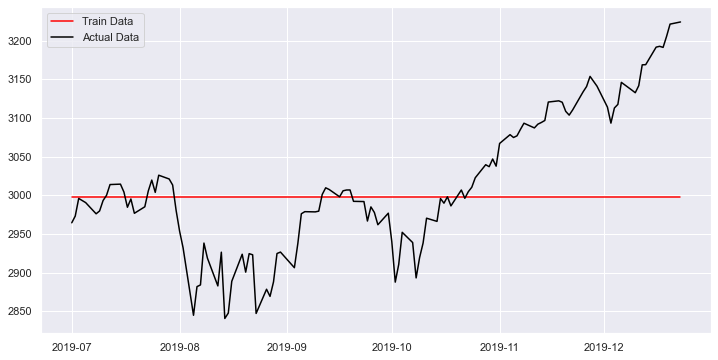

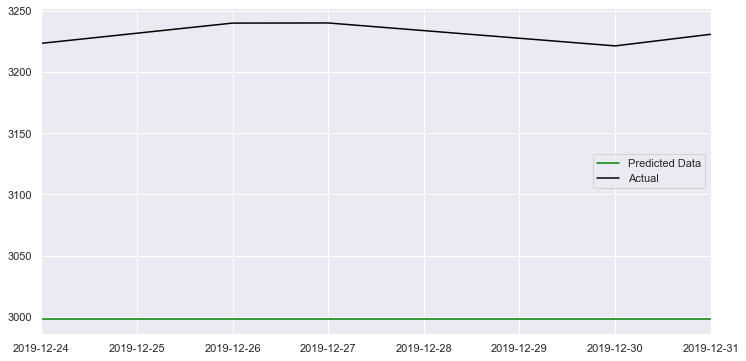

In [18]:
predict_multiple_variables(_GSPC, _GSPC_dates, num_forecast_days=5, C_user=1000, G_user=.0001,model =  'sigmoid')